Mean Squared Error: 5.403574999727789e-06


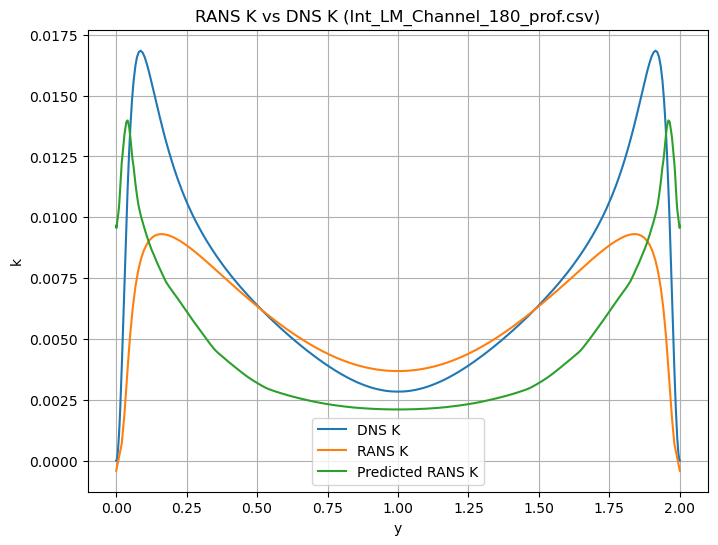

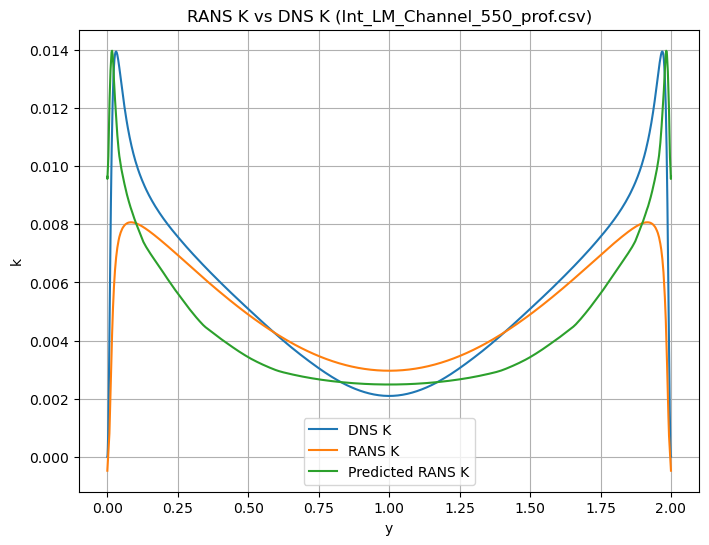

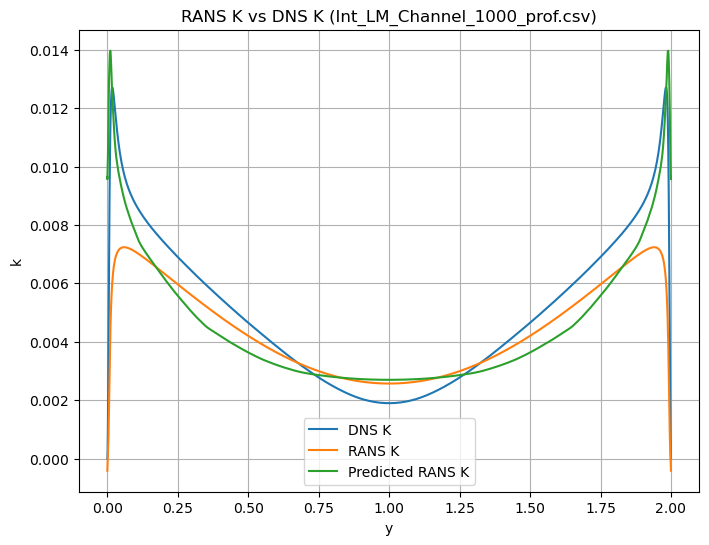

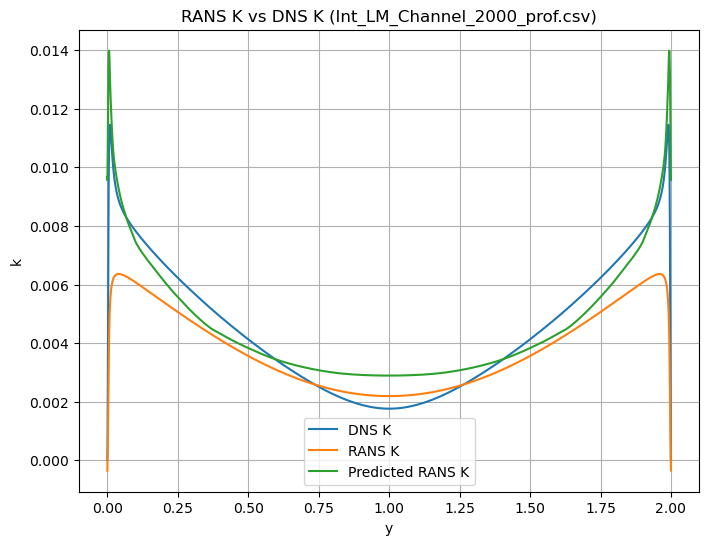

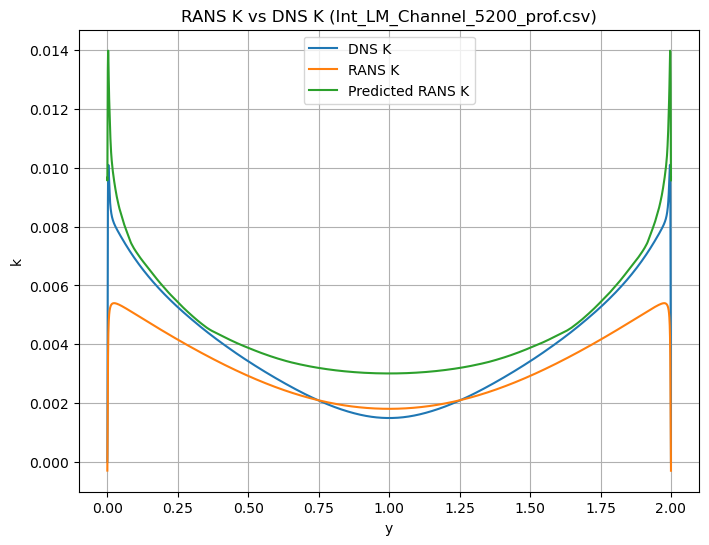

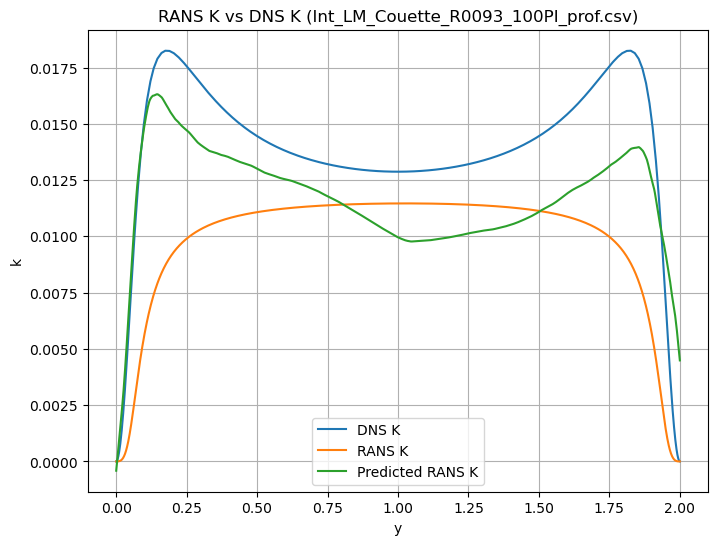

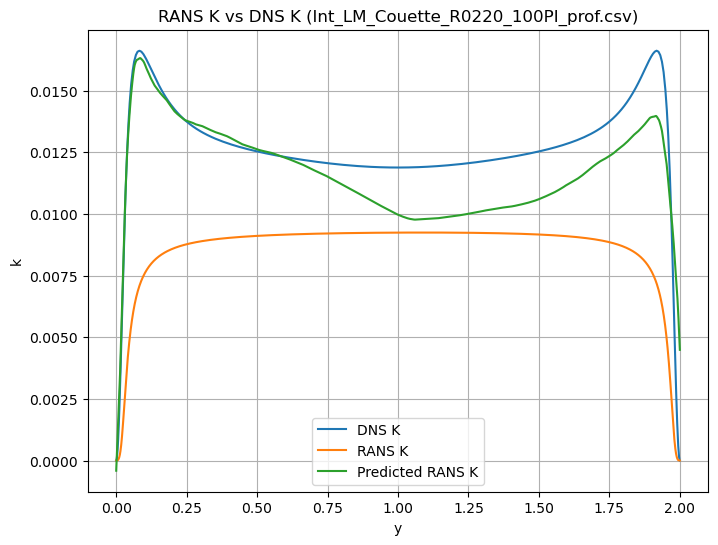

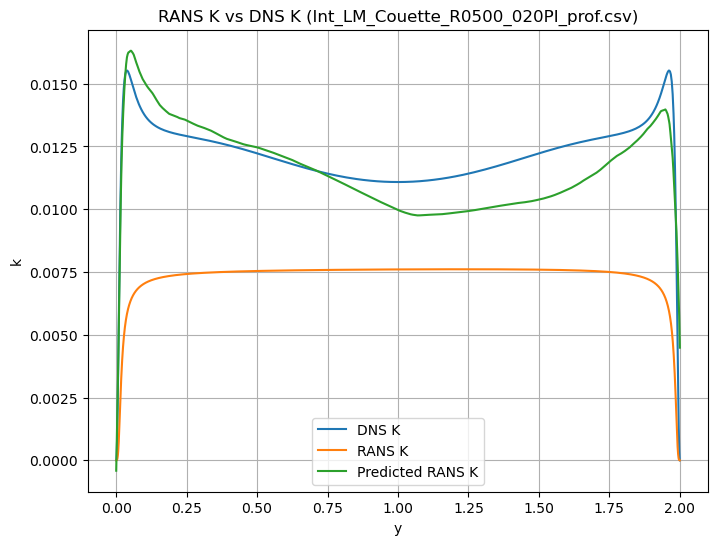

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

file_names = ['Int_LM_Channel_180_prof.csv', 'Int_LM_Channel_550_prof.csv', 'Int_LM_Channel_1000_prof.csv', 'Int_LM_Channel_2000_prof.csv', 'Int_LM_Channel_5200_prof.csv', 'Int_LM_Couette_R0093_100PI_prof.csv', 'Int_LM_Couette_R0220_100PI_prof.csv', 'Int_LM_Couette_R0500_020PI_prof.csv']

# Process each file and apply the subtraction where needed before concatenating
processed_data = []

for file_name in file_names:
    df = pd.read_csv(file_name)
    
    if 'Couette' in file_name:
        df['xvel'] = df['xvel'] - 1
    
    # Calculate the second derivative of xvel over y (approximated using finite differences)
    y_values = df['y'].values
    first_derivative_values = df['dxdy'].values
    second_derivative = np.gradient(first_derivative_values, y_values)
    
    # Add the second derivative as a new column to the dataframe
    df['d2xdy2'] = second_derivative
    
    processed_data.append(df)

# Aggregate processed data from all files
all_data = pd.concat(processed_data, ignore_index=True)

# Prepare the aggregated dataset for training
X = all_data[['dzdz', 'xvel', 't_visc']]
y = all_data['DNS_k']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a neural network model
model = MLPRegressor(hidden_layer_sizes=(1000, 1000), activation='relu', solver='adam', max_iter=100000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Iterate through each file for predictions and plotting
for file_name in file_names:
    df = pd.read_csv(file_name)
    if 'Couette' in file_name:
        df['xvel'] = df['xvel'] - 1

    # Assuming the second derivative needs to be recalculated if you want to use updated values for plotting
    y_values = df['y'].values
    first_derivative_values = df['dxdy'].values
    second_derivative = np.gradient(first_derivative_values, y_values)
    df['d2xdy2'] = second_derivative
    
    X_pred = df[['dzdz', 'xvel', 't_visc']]
    
    df['Predicted_RANS_k'] = model.predict(X_pred)
    
    plt.figure(figsize=(8, 6))
    plt.plot(df['y'], df['DNS_k'], label='DNS K')
    plt.plot(df['y'], df['RANS_k'], label='RANS K')
    plt.plot(df['y'], df['Predicted_RANS_k'], label='Predicted RANS K')
    plt.xlabel('y')
    plt.ylabel('k')
    plt.title(f'RANS K vs DNS K ({file_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

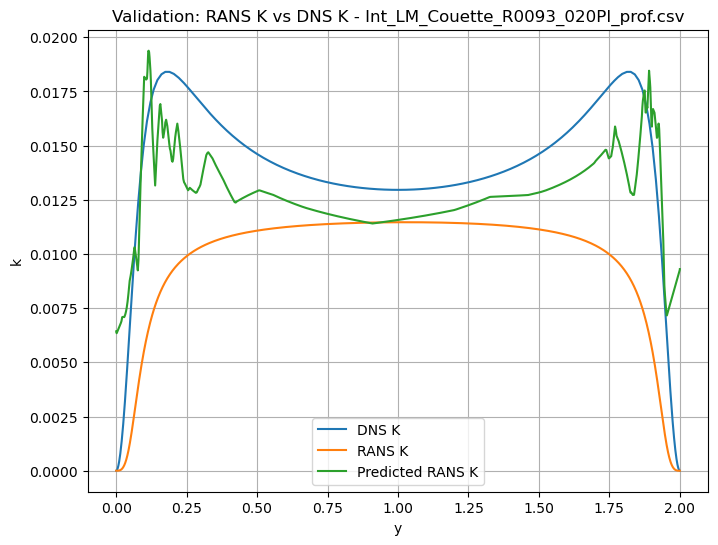

In [30]:
# List of CSV files for validation

# csv_files = ['Int_LM_Couette_R0093_020PI_prof.csv', 'Int_LM_Couette_R0093_100PI_prof.csv', 'Int_LM_Couette_R0220_020PI_prof.csv', 'Int_LM_Couette_R0220_100PI_prof.csv', 'Int_LM_Couette_R0500_020PI_prof.csv', 'Int_LM_Couette_R0500_100PI_prof.csv']  # Add more file names as needed
csv_files = ['Int_LM_Couette_R0093_020PI_prof.csv']
# csv_files = ['Int_LM_Channel_180_prof.csv', 'Int_LM_Channel_550_prof.csv', 'Int_LM_Channel_1000_prof.csv', 'Int_LM_Channel_2000_prof.csv', 'Int_LM_Channel_5200_prof.csv']
# csv_files = ['Int_LM_Channel_1000_prof.csv']

# Iterate over each CSV file
for file in csv_files:
    # Read the separate CSV file for validation
    validation_df = pd.read_csv(file)
    
    # Subtract 1 from the 'xvel' column
    # validation_df['xvel'] -= 1

    # Prepare the validation dataset
    X_validation = validation_df[['dzdy', 'dxdy', 'dzdz', 'xvel']]

    # Predict RANS_k for the validation dataset
    validation_df['Predicted_RANS_k'] = model.predict(X_validation)

    # Plot DNS_k, original RANS_k, and predicted RANS_k for the validation dataset
    plt.figure(figsize=(8, 6))
    plt.plot(validation_df['y'], validation_df['DNS_k'], label = 'DNS K')
    plt.plot(validation_df['y'], validation_df['RANS_k'], label = 'RANS K')
    plt.plot(validation_df['y'], validation_df['Predicted_RANS_k'], label = 'Predicted RANS K')
    plt.xlabel('y')
    plt.ylabel('k')
    plt.title(f'Validation: RANS K vs DNS K - {file}')
    plt.legend()
    plt.grid(True)
    plt.show()